In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from ultralytics import YOLO

In [2]:
from code_programm.path import get_path_weight_model

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

1
NVIDIA GeForce GTX 1080 Ti


In [4]:
# model = YOLO(get_path_model('yolov8s-seg.pt'))

In [5]:
# model = YOLO(get_path_model('yolov8s-seg.pt'))

In [6]:
model = YOLO(get_path_weight_model('best_v1_n.pt'))
# model = YOLO(get_path_weight_model('yolov8s-seg_v3.pt'))

In [7]:
img = cv2.imread(r'C:\PycharmProjects\ETS_Autopilot\static\settings_cache\1708818279.8189156.png')
print(img.shape)

(500, 500, 3)


In [8]:
results = model(img, imgsz=512, conf=0.75, verbose=True, show=True)

0: 512x512 3 markups, 2 markup_lines, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 342.1ms postprocess per image at shape (1, 3, 512, 512)


In [9]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'markup', 1: 'markup_line'}
 obb: None
 orig_img: array([[[229, 198, 179],
         [231, 201, 183],
         [233, 205, 188],
         ...,
         [240, 208, 185],
         [240, 208, 184],
         [240, 208, 184]],
 
        [[228, 198, 178],
         [229, 199, 180],
         [231, 201, 183],
         ...,
         [240, 207, 184],
         [239, 207, 183],
         [239, 207, 184]],
 
        [[228, 198, 178],
         [228, 199, 179],
         [229, 200, 181],
         ...,
         [239, 206, 182],
         [238, 206, 182],
         [238, 206, 182]],
 
        ...,
 
        [[144, 148, 157],
         [148, 153, 162],
         [138, 144, 150],
         ...,
         [133, 142, 145],
         [128, 136, 138],
         [141, 148, 151]],
 
        [[144, 149, 156],
         [137, 142, 148],
     

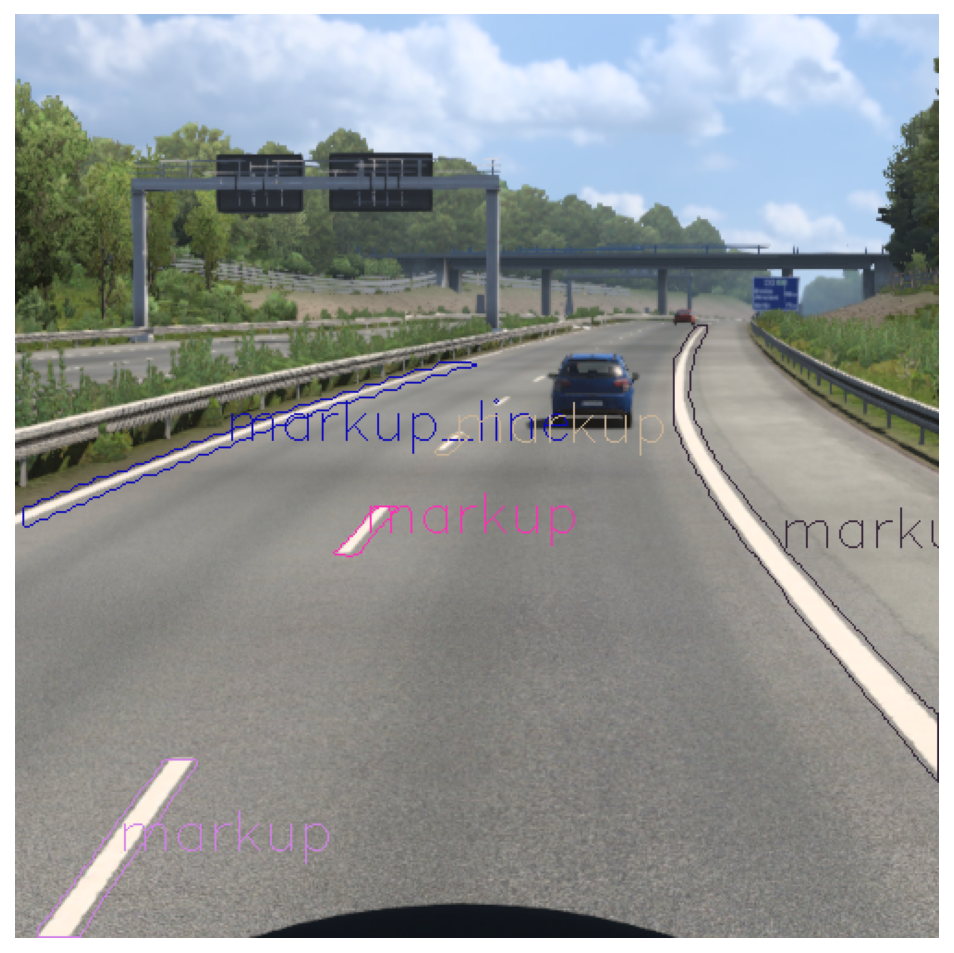

In [10]:
# Получение классов и имен классов
classes = results[0].boxes.cls.cpu().numpy()
class_names = results[0].names

# Получение бинарных масок и их количество
masks = results[0].masks.data  # Формат: [число масок, высота, ширина]
num_masks = masks.shape[0]

# Определение случайных цветов и прозрачности для каждой маски
colors = [tuple(np.random.randint(0, 256, 3).tolist()) for _ in range(num_masks)]  # Случайные цвета

# Создание изображения для отображения масок
mask_overlay = np.zeros_like(img)

labeled_image = img.copy()

# Добавление подписей к маскам
for i in range(num_masks):
    color = colors[i]  # Случайный цвет
    mask = masks[i].cpu()

    # Изменение размера маски до размеров исходного изображения с использованием метода ближайших соседей
    mask_resized = cv2.resize(np.array(mask), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Получение класса для текущей маски
    class_index = int(classes[i])
    class_name = class_names[class_index]

    # Добавление подписи к маске
    mask_contours, _ = cv2.findContours(mask_resized.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(labeled_image, mask_contours, -1, color, 1)
    cv2.putText(labeled_image, class_name,
                (int(mask_contours[0][:, 0, 0].mean()), int(mask_contours[0][:, 0, 1].mean())),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1)

# Отобразите итоговое изображение с наложенными масками и подписями
plt.figure(figsize=(8, 8), dpi=150)
labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB)
plt.imshow(labeled_image)
plt.axis('off')
plt.savefig('output.png')
plt.show()

In [14]:
import os

path = r'C:\PycharmProjects\ETS_Autopilot\static\datasets\validation\images'

for filename in os.listdir(path):
    if filename.endswith('.png'):
        try:
            image_path = os.path.join(path, filename)
            # Загрузка изображения
            img = cv2.imread(image_path)
            results = model(img, imgsz=512, conf=0.65, verbose=True)
            # Получение классов и имен классов
            classes = results[0].boxes.cls.cpu().numpy()
            class_names = results[0].names

            # Получение бинарных масок и их количество
            masks = results[0].masks.data  # Формат: [число масок, высота, ширина]
            num_masks = masks.shape[0]

            # Определение случайных цветов и прозрачности для каждой маски
            colors = [tuple(np.random.randint(0, 256, 3).tolist()) for _ in range(num_masks)]  # Случайные цвета

            # Создание изображения для отображения масок
            mask_overlay = np.zeros_like(img)

            labeled_image = img.copy()

            # Добавление подписей к маскам
            for i in range(num_masks):
                color = colors[i]  # Случайный цвет
                mask = masks[i].cpu()

                # Изменение размера маски до размеров исходного изображения с использованием метода ближайших соседей
                mask_resized = cv2.resize(np.array(mask), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

                # Получение класса для текущей маски
                class_index = int(classes[i])
                class_name = class_names[class_index]

                # Добавление подписи к маске
                mask_contours, _ = cv2.findContours(mask_resized.astype(np.uint8), cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(labeled_image, mask_contours, -1, color, 1)
                cv2.putText(labeled_image, class_name,
                            (int(mask_contours[0][:, 0, 0].mean()), int(mask_contours[0][:, 0, 1].mean())),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1)

            # Отобразите итоговое изображение с наложенными масками и подписями
            plt.figure(figsize=(8, 8), dpi=150)
            labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB)
            plt.imshow(labeled_image)
            plt.axis('off')
            plt.savefig(os.path.join('C:\\PycharmProjects\\ETS_Autopilot\\static\\settings_cache', f'{filename}'))
            plt.clf()
        except InterruptedError:
            print('User interrupted')


0: 512x512 4 markups, 2 markup_lines, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 6 markups, 1 markup_line, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 4 markups, 2 markup_lines, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 5.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 2 markup_lines, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3

C:\Users\filip\AppData\Local\Temp\ipykernel_1592\4238738819.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8), dpi=150)



0: 512x512 3 markups, 3 markup_lines, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 markups, 2 markup_lines, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 markups, 2 markup_lines, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 markups, 1 markup_line, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 markups, 2 markup_lines, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 markups, 2 markup_lines, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 markups, 1 markup_line, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 3 mar

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [15]:
import cv2

# Define the cropping dimensions
left = 710
top = 230
width = 512
height = 512

# Define input and output video paths
input_video_path = r'C:\PycharmProjects\ETS_Autopilot\static\settings_cache\Euro Truck Simulator 2 2024.01.07 - 02.13.42.04.DVR.mp4'
output_video_path = r'C:\PycharmProjects\ETS_Autopilot\static\settings_cache\cropped_video_2.mp4'

# Open the input video file
cap = cv2.VideoCapture(input_video_path)

# Get the video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Process each frame and crop it
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Crop the frame
    cropped_frame = frame[top:top + height, left:left + width]

    # Write the cropped frame to the output video
    out.write(cropped_frame)

# Release the video capture and writer objects
cap.release()
out.release()

# Close all OpenCV windows
cv2.destroyAllWindows()

In [9]:
import cv2

# Загрузить видео
video_path = r'C:\PycharmProjects\ETS_Autopilot\app\static\settings_cache\cropped_video_2.mp4'
cap = cv2.VideoCapture(video_path)

# Зациклить по кадрам
while True:
    # Считать кадр
    ret, frame = cap.read()

    # Обработать кадр с помощью YOLO
    detections = model.predict(frame, imgsz=512, conf=0.65, show=True)

    # Завершить цикл при нажатии клавиши
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


0: 512x512 2 markup_lines, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 markup_lines, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 markup_lines, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 2 markup_lines, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)
0: 512x512 4 markup_lines, 8.0ms
Speed: 0.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 markup_lines, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 markup_lines, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 3.0ms postprocess

In [1]:
# Выходной путь для видео
output_path = "output.mp4"

# Кодек для видео
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Размер кадра
width = frame.shape[1]
height = frame.shape[0]

# Создать объект VideoWriter
writer = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))

# Записать кадры в видео
while True:
    # Обработать кадр с помощью YOLO
    detections = model.predict(frame, imgsz=512, conf=0.65, show=True)

    # Записать кадр
    writer.write(frame)

    # Завершить цикл при нажатии клавиши
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Закрыть VideoWriter
writer.release()

NameError: name 'cv2' is not defined